## Content
- The dataset is a CSV, where each row is a tweet. The different columns are described below. Every conversation included has at least one request from a consumer and at least one response from a company. Which user IDs are company user IDs can be calculated using the inbound field.

### tweet_id
- A unique, anonymized ID for the Tweet. Referenced by response_tweet_id and in_response_to_tweet_id.

### author_id
- A unique, anonymized user ID. @s in the dataset have been replaced with their associated anonymized user ID.

### inbound
- Whether the tweet is "inbound" to a company doing customer support on Twitter. This feature is useful when re-organizing data for training conversational models.

### created_at
- Date and time when the tweet was sent.

### text
- Tweet content. Sensitive information like phone numbers and email addresses are replaced with mask values like __email__.

### response_tweet_id
- IDs of tweets that are responses to this tweet, comma-separated.

### in_response_to_tweet_id
- ID of the tweet this tweet is in response to, if any.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import findspark
findspark.init()

from pyspark import SparkConf
from pyspark import SparkContext

sc = SparkContext(appName="Project")

pd.set_option('display.max_colwidth', -1)

In [2]:
#Read in data
df = pd.read_csv('twcs/twcs.csv')
data = df.copy()

In [3]:
data.head(20)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist you. We would need to get you into a private secured link to further assist.,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messages and no one is responding as usual,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so that we can further assist you. Just click ‘Message’ at the top of your profile.,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
5,6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,"@115712 Can you please send us a private message, so that I can gain further details about your account?","5,7",8.0
6,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN
7,11,sprintcare,False,Tue Oct 31 22:10:35 +0000 2017,"@115713 This is saddening to hear. Please shoot us a DM, so that we can look into this for you. -KC",NaN,12.0
8,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your connectivity for me and my whole family ? 🤥 💯,"11,13,14",15.0
9,15,sprintcare,False,Tue Oct 31 20:03:31 +0000 2017,"@115713 We understand your concerns and we'd like for you to please send us a Direct Message, so that we can further assist you. -AA",12,16.0


In [4]:
data.info()  #Checking data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2811774 entries, 0 to 2811773
Data columns (total 7 columns):
tweet_id                   int64
author_id                  object
inbound                    bool
created_at                 object
text                       object
response_tweet_id          object
in_response_to_tweet_id    float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 131.4+ MB


In [5]:
data.describe()

,tweet_id,in_response_to_tweet_id
count,2.811774e+06,2.017439e+06
mean,1.504565e+06,1.463141e+06
std,8.616450e+05,8.665730e+05
min,1.000000e+00,1.000000e+00
25%,7.601652e+05,7.155105e+05
50%,1.507772e+06,1.439805e+06
75%,2.253296e+06,2.220646e+06
max,2.987950e+06,2.987950e+06


In [6]:
#Missing info check
data.isnull().sum()

tweet_id                   0      
author_id                  0      
inbound                    0      
created_at                 0      
text                       0      
response_tweet_id          1040629
in_response_to_tweet_id    794335 
dtype: int64

In [7]:
print("The response rate is {} %".format(2017439 /2811774 * 100))

The response rate is 71.74968542991009 %


In [8]:
#Extract the customer support company
data['customer_support_name'] = data['author_id'].str.extract('([a-zA-Z ]+)', expand=False).str.strip()

In [9]:
#Take 20 highest tweet count
count_tweet = data['tweet_id'].groupby(data['customer_support_name']).count().to_frame().reset_index()
ordered_count = count_tweet.nlargest(20, 'tweet_id')

Text(0, 0.5, 'Tweet Count')

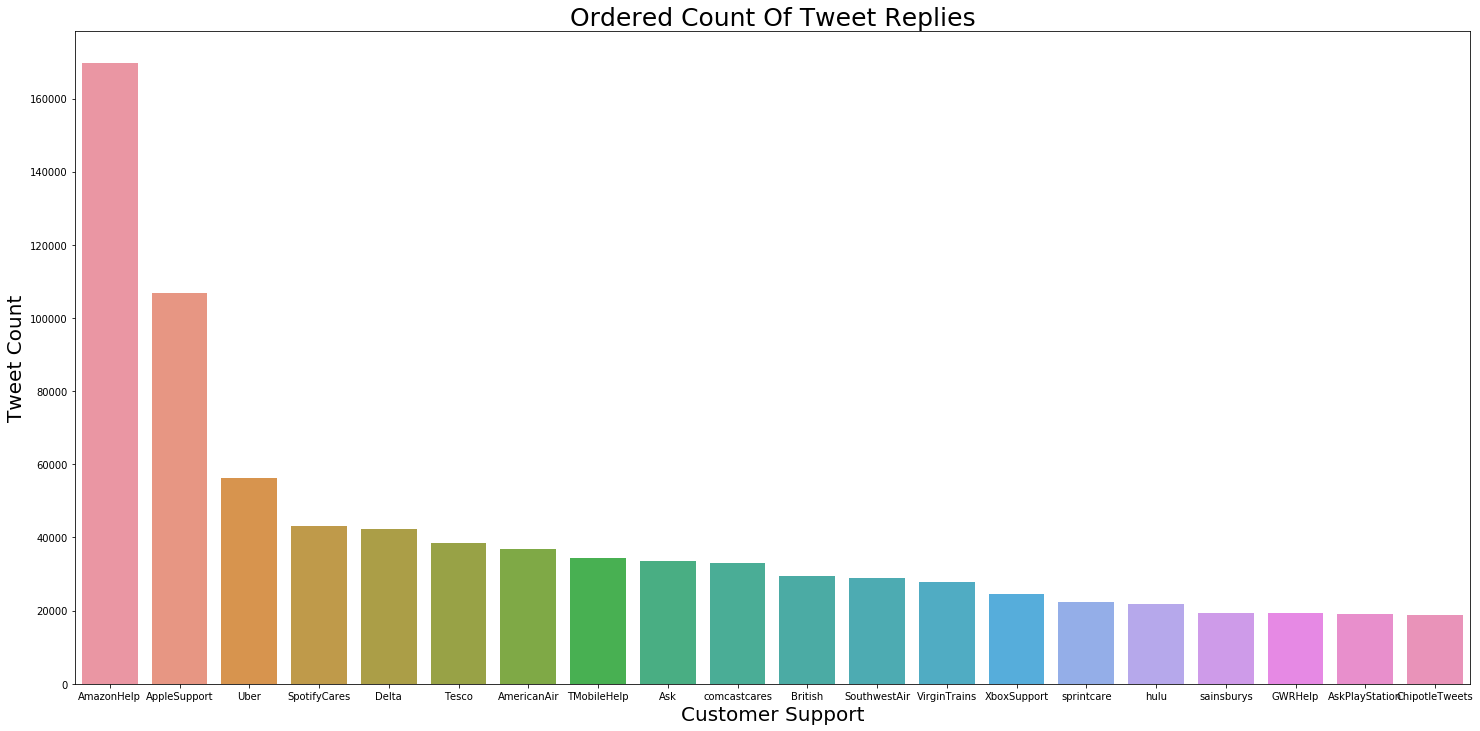

In [10]:
#Visualizing our data
plt.figure(figsize=(25, 12))
sns.barplot(x = ordered_count['customer_support_name'], y = ordered_count['tweet_id'])
plt.title('Ordered Count Of Tweet Replies', fontsize = 25)
plt.xlabel('Customer Support', fontsize = 20)
plt.ylabel('Tweet Count', fontsize = 20)

In [11]:
#Cleaning up text column
words = ' '.join(data['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

In [12]:
#Set up and generate word cloud
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

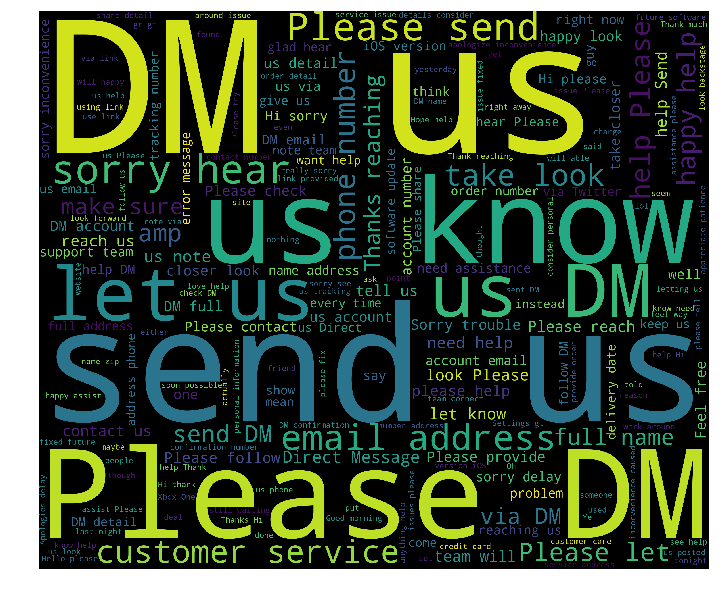

In [13]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [17]:
stop_words = set(stopwords.words('english'))
stop_words.add('u')
wordnet_lemmatizer = WordNetLemmatizer()

def normalizer(tweet):
    tweet = " ".join([word for word in tweet.split() if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'])
    only_letters = re.sub("[^a-zA-Z]", " ",tweet) 
    tokens = nltk.word_tokenize(only_letters)[2:]
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = " ".join(wordnet_lemmatizer.lemmatize(t) for t in filtered_result)
    return lemmas

In [13]:
normalizer("@115714 whenever I contact customer support, they tell me I have shortcode enabled on my account, but I have never in the 4 years I've tried https://t.co/0G98RtNxPK	.")

'contact customer support tell shortcode enabled account never year tried'

In [14]:
#Normalize the text
data['normalized_tweet'] = data.text.apply(normalizer)

In [15]:
data.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,normalized_tweet
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist you. We would need to get you into a private secured link to further assist.,2,3.0,would like assist would need get private secured link assist
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,propose
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messages and no one is responding as usual,1,4.0,sent several private message one responding usual
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so that we can further assist you. Just click ‘Message’ at the top of your profile.,3,5.0,u private message assist click message top profile
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,


In [16]:
#Count of word prequencies
data.normalized_tweet.str.split(expand=True).stack().value_counts()

u                     470925
please                341399
dm                    336308
help                  273125
get                   201285
issue                 150815
service               150544
look                  145166
like                  139366
know                  139140
account               134664
send                  132268
sorry                 132034
number                130585
time                  128060
thanks                120885
phone                 119708
let                   116512
email                 115865
team                  98593 
back                  98325 
need                  96728 
address               96724 
order                 95728 
day                   92254 
detail                89773 
amp                   88114 
customer              86253 
hear                  85585 
check                 84937 
                      ...   
metier                1     
beautifuls            1     
melburnians           1     
simlar        